In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report  #这个包是评价报告
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_1=sio.loadmat('/Users/yangguangqiang/Music/career-2021/ML-startup/吴恩达/ML-homework-main/ex4-NN back propagation/ex4data1.mat')
data_x=data_1["X"]
data_y=data_1["y"]
print(data_x.shape) # 5000个训练示例；每一张图是一个 20X20 的矩阵  
print(data_y.shape) #Y: 5000-dimensional vector 记录所有图片的分类

(5000, 400)
(5000, 1)


In [7]:
### visualize picture
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(6, 6))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

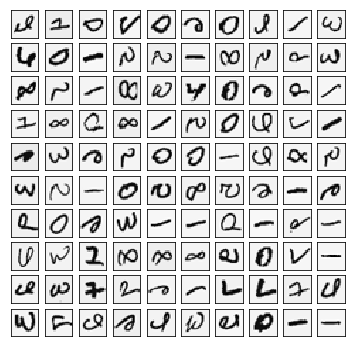

In [8]:
plot_100_image(data_x)
plt.show()

In [ ]:
## Feedforward and sum cost 

In [3]:
data_w=sio.loadmat('/Users/yangguangqiang/Music/career-2021/ML-startup/吴恩达/ML-homework-main/ex4-NN back propagation/ex4weights.mat')
print(data_w['Theta1'].shape,data_w['Theta2'].shape)
Theta=np.concatenate((np.ravel(data_w['Theta1']), np.ravel(data_w['Theta2'])))

(25, 401) (10, 26)


In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def feed_forward(theta_1,theta_2,X):
    a_1=X
    z_2=np.dot(a_1,theta_1.T)

    a_2=np.insert(sigmoid(z_2), 0, np.ones(z_2.shape[0]), axis=1) #注意，先sigmoid,再插入 1
    z_3=np.dot(a_2,theta_2.T)
    a_3=sigmoid(z_3)
    return a_1,z_2,a_2,z_3,a_3

## init data !!!

In [6]:
X=np.insert(data_x, 0, values=1, axis=1)
Y=np.zeros([5000,10])
for f in range(len(data_y)):
    Y[f][data_y[f][0]-1]=1

In [7]:
h=feed_forward(data_w['Theta1'],data_w['Theta2'], X)[-1]
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [7]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))
def deserialize(seq):
    return seq[ : 25*401].reshape(25, 401), seq[25*401 : ].reshape(10, 26)
def cost(theta_1,theta_2, X, Y):
    h = feed_forward(theta_1,theta_2,X)[-1]
    temp = (1 - Y) * np.log(1 - h)+Y* np.log(h)
    return -1*temp.sum()/len(X)  #矩阵不能再用 mean了
def regularize_cost(theta, X, Y,fi=1):
    theta_1,theta_2 = deserialize(theta)
    third=(fi / (2 * len(X))) * np.power(theta_1[:,1:],2).sum()+(fi / (2 * len(X))) * np.power(theta_2[:,1:],2).sum()
    return cost(theta_1,theta_2, X, Y)+third

In [8]:
print(regularize_cost(Theta, X, Y,fi=1))
print(cost(data_w['Theta1'],data_w['Theta2'], X, Y))

0.38376985909092365
0.2876291651613189


In [9]:
## 反向传播

In [9]:
def deri_sigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

In [10]:
def back_gradient(theta_1,theta_2, X, Y):
    
    delta1 = np.zeros(theta_1.shape) # 25*401
    delta2 = np.zeros(theta_2.shape) # 10*26
    
    a1, z2, a2, z3, h = feed_forward(theta_1,theta_2, X)  # from forward get certain parameters
    
    for i in range(len(X)):  #一层一层算
        a_1i = a1[i] # 1*401
        z_2i = z2[i] # 1*25
        a_2i = a2[i] # 1*26

        hi  = h[i]  # 1*10
        Yi  = Y[i]  # 1*10
        delta_3i = hi - Yi # 1*10，输出层的误差
        
        z_2i = np.insert(z_2i, 0, np.ones(1))  # [1,X]
        delta_2i = theta_2.T @ delta_3i * deri_sigmoid(z_2i) # 1*26 隐藏层的误差
        
        delta2 += np.matrix(delta_3i).T @ np.matrix(a_2i)
        delta1 += np.matrix(delta_2i[1:]).T @ np.matrix(a_1i)
    
    return delta1, delta2

In [11]:
def regularized_gradient(theta, X, Y, fi=1):
    m=len(X)
    theta_1,theta_2 = deserialize(theta)
    delta_1,delta_2=back_gradient(theta_1,theta_2, X, Y)
    delta_1,delta_2=delta_1/m,delta_2/m
    
    theta_1[:,0]=0
    theta_2[:,0]=0
    
    delta_1,delta_2=(delta_1+delta_1*(fi/m)),(delta_2+delta_2*(fi/m))
    return serialize(delta_1,delta_2)

In [45]:
## 梯度检查

In [46]:
def repli_array(arr):   #[1, 2, 3] in to ([[1, 2, 3],[1, 2, 3],[1, 2, 3]])   
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))
def gradient_checking(theta, X, y, epsilon, regularized=False):




SyntaxError: unexpected EOF while parsing (<ipython-input-46-75ce2395ff82>, line 5)

In [ ]:
## 开始 train model

In [18]:
def random_init(size):
    return np.random.uniform(-0.12,0.12,size) #随机生成 区间内 size 个数
def nn_training(theta, X, Y):
    init_theta=random_init(len(Theta))
    result=opt.minimize(fun=regularize_cost, x0=(init_theta) , 
                                  args=(X, Y,1), method='TNC', jac=regularized_gradient,options={'maxiter': 300})
    return result

In [19]:
res = nn_training(Theta, X,Y) # 慢
res

<ipython-input-7-bb0a52e2ad8d>:7: RuntimeWarning: divide by zero encountered in log
  temp = (1 - Y) * np.log(1 - h)+Y* np.log(h)
<ipython-input-7-bb0a52e2ad8d>:7: RuntimeWarning: invalid value encountered in multiply
  temp = (1 - Y) * np.log(1 - h)+Y* np.log(h)


     fun: 0.4316637291872279
     jac: array([-1.09621290e-03,  0.00000000e+00,  0.00000000e+00, ...,
        1.59590574e-04,  7.56318769e-04,  9.22488782e-05])
 message: 'Linear search failed'
    nfev: 235
     nit: 16
  status: 4
 success: False
       x: array([ 0.54148953, -0.0612885 ,  0.11843999, ...,  1.06855122,
       -0.26796285, -4.59902321])

In [22]:
Theta_1,Theta_2=deserialize(res.x)
_, _, _, _, h = feed_forward(Theta_1,Theta_2, X)
y_pred = np.argmax(h, axis=1) + 1
print(classification_report(data_y, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.98      0.98       500
           2       0.98      0.98      0.98       500
           3       0.97      0.96      0.96       500
           4       0.97      0.98      0.98       500
           5       0.97      0.97      0.97       500
           6       1.00      0.99      0.99       500
           7       0.99      0.99      0.99       500
           8       0.98      0.99      0.98       500
           9       0.97      0.97      0.97       500
          10       0.99      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



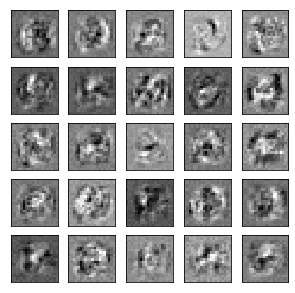

In [23]:
def plot_hidden_layer(theta):
    t1, t2 = deserialize(theta)
    hidden_layer = t1[:, 1:]
    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5,5))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5*r+c].reshape((20,20)), 
                                  cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))            
    plt.show()
plot_hidden_layer(res.x)